# SHAP Values
Understand individual predictions

# 🧠 Introduction to SHAP Values

we've already explored techniques to understand a model’s overall behavior. But what if we want to **break down how a model makes a specific prediction** for a single data point? 🔍

**SHAP Values** — **SHapley Additive exPlanations**. This method allows us to **decompose individual predictions** and see the contribution of each feature.

---

## 📌 Why Use SHAP?

Imagine situations like:

- 🏦 A bank refuses a loan and must legally explain why ❗  
- 🏥 A doctor wants to understand which risk factors contribute most to a patient’s disease prediction 🧬  

In both cases, **global feature importance isn’t enough** — we need **local interpretability**.

---

## ⚙️ How It Works

SHAP values compare the **actual value** of a feature to a **baseline**, showing how much that feature **pushes the prediction up or down**.

For example, in predicting a football team’s "Man of the Match" award 🏆:

- Instead of asking _"What’s the effect of scoring 3 goals?"_, we ask:
  > _"What’s the effect of scoring 3 goals compared to the baseline (say 1 goal)?"_

SHAP values **do this for all features** and **guarantee** this equation:

Prediction = Baseline Prediction + SHAP Values


So we can explain **why** the model deviates from the baseline.

In [36]:
import pandas as pd
data = pd.read_csv('hospital-readmissions.csv')
data.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'race_Caucasian',
       'race_AfricanAmerican', 'gender_Female', 'age_[70-80)', 'age_[60-70)',
       'age_[50-60)', 'age_[80-90)', 'age_[40-50)', 'payer_code_?',
       'payer_code_MC', 'payer_code_HM', 'payer_code_SP', 'payer_code_BC',
       'medical_specialty_?', 'medical_specialty_InternalMedicine',
       'medical_specialty_Emergency/Trauma',
       'medical_specialty_Family/GeneralPractice',
       'medical_specialty_Cardiology', 'diag_1_428', 'diag_1_414',
       'diag_1_786', 'diag_2_276', 'diag_2_428', 'diag_2_250', 'diag_2_427',
       'diag_3_250', 'diag_3_401', 'diag_3_276', 'diag_3_428',
       'max_glu_serum_None', 'A1Cresult_None', 'metformin_No',
       'repaglinide_No', 'nateglinide_No', 'chlorpropamide_No',
       'glimepiride_No', 'acetohexamide_No', 'glipizide_No', 'glyburide_No',
     

Here are some quick hints at interpreting the field names:

- Our prediction target is `readmitted`
- Columns with the word `diag` indicate the diagnostic code of the illness or illnesses the patient was admitted with. For example, `diag_1_428` means the doctor said their first illness diagnosis is number "428".  What illness does 428 correspond to? We could look it up in a codebook, but without more medical background it wouldn't mean anything to us anyway.
- A column names like `glimepiride_No` mean the patient did not have the medicine `glimepiride`. If this feature had a value of False, then the patient did take the drug `glimepiride`
- Features whose names begin with `medical_specialty` describe the specialty of the doctor seeing the patient. The values in these fields are all `True` or `False`.


### Step 1
We have built a simple model, but the doctors say they don't know how to evaluate a model, and they'd like you to show them some evidence the model is doing something in line with their medical intuition. Create any graphics or tables that will show them a quick overview of what the model is doing?

In [37]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

data = pd.read_csv('hospital-readmissions.csv')

y = data.readmitted

base_features = [c for c in data.columns if c != "readmitted"]

X = data[base_features]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=30, random_state=1).fit(train_X, train_y)

Let's create the materials for the doctors.

In [38]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.0451 ± 0.0068,number_inpatient
0.0087 ± 0.0046,number_emergency
0.0062 ± 0.0053,number_outpatient
0.0033 ± 0.0016,payer_code_MC
0.0020 ± 0.0016,diag_3_401
0.0016 ± 0.0031,medical_specialty_Emergency/Trauma
0.0014 ± 0.0024,A1Cresult_None
0.0014 ± 0.0021,medical_specialty_Family/GeneralPractice
0.0013 ± 0.0010,diag_2_427
0.0013 ± 0.0011,diag_2_276


### Step 2

It appears `number_inpatient` is a really important feature. The doctors would like to know more about that. Create a graph for them that shows how `num_inpatient` affects the model's predictions.

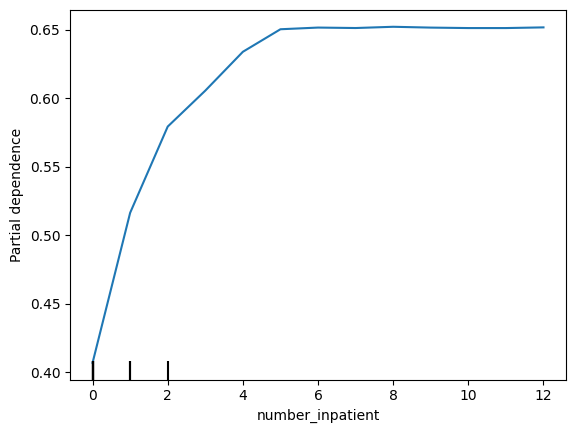

In [39]:
from matplotlib import pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

feature_name = 'number_inpatient'
PartialDependenceDisplay.from_estimator(my_model, val_X, [feature_name])
plt.show()

### Step 3

The doctors think it's a good sign that increasing the number of inpatient procedures leads to increased predictions.  But they can't tell from this plot whether that change in the plot is big or small. They'd like you to create something similar for `time_in_hospital` to see how that compares.

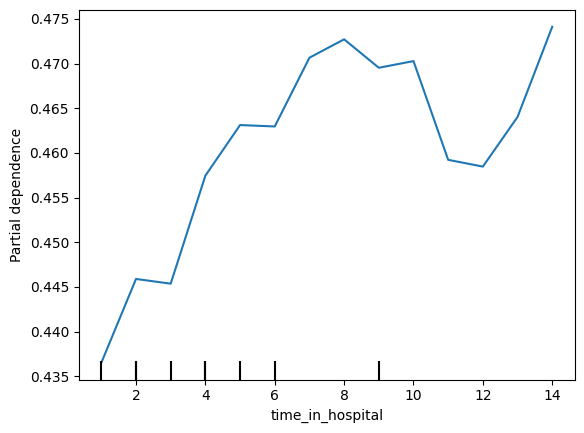

In [40]:
feature_name = 'time_in_hospital'
PartialDependenceDisplay.from_estimator(my_model, val_X, [feature_name])
plt.show()

-->>The results are very different. Specifically time in hospital has a much smaller effect.

### Step 4

Woah!  It seems like `time_in_hospital` doesn't matter at all.  The difference between the lowest value on the partial dependence plot and the highest value is about 5%.

If that is what your model concluded, the doctors will believe it. But it seems so low. Could  the data be wrong, or is your model doing something more complex than they expect?  

They'd like you to show them the raw readmission rate for each value of `time_in_hospital` to see how it compares to the partial dependence plot.

- Make that plot. 
- Are the results similar or different?

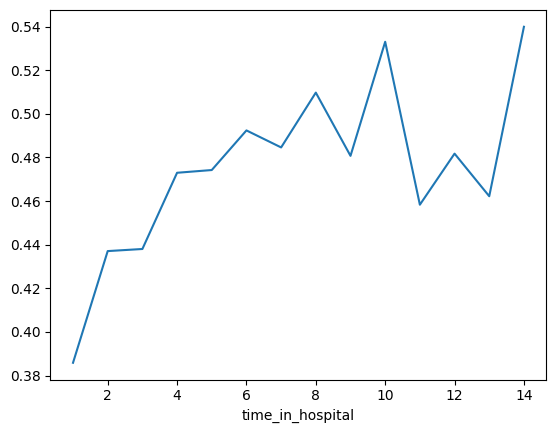

In [41]:
all_train = pd.concat([train_X, train_y], axis=1)

all_train.groupby(['time_in_hospital']).mean().readmitted.plot()
plt.show()

### Step 5
Now the doctors are convinced you have the right data, and the model overview looked reasonable.  It's time to turn this into a finished product they can use. Specifically, the hospital wants you to create a function `patient_risk_factors` that does the following
- Takes a single row with patient data (of the same format you as your raw data)
- Creates a visualization showing what features of that patient increased their risk of readmission, what features decreased it, and how much those features mattered.

In [42]:
import shap 

sample_data_for_prediction = val_X.iloc[0].astype(float)  # to test function

def patient_risk_factors(model, patient_data):
    # Create object that can calculate shap values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient_data)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient_data)

# Advanced Uses of SHAP Values

<class 'numpy.ndarray'>
(150, 15, 2)
(150, 15)
(150, 15)


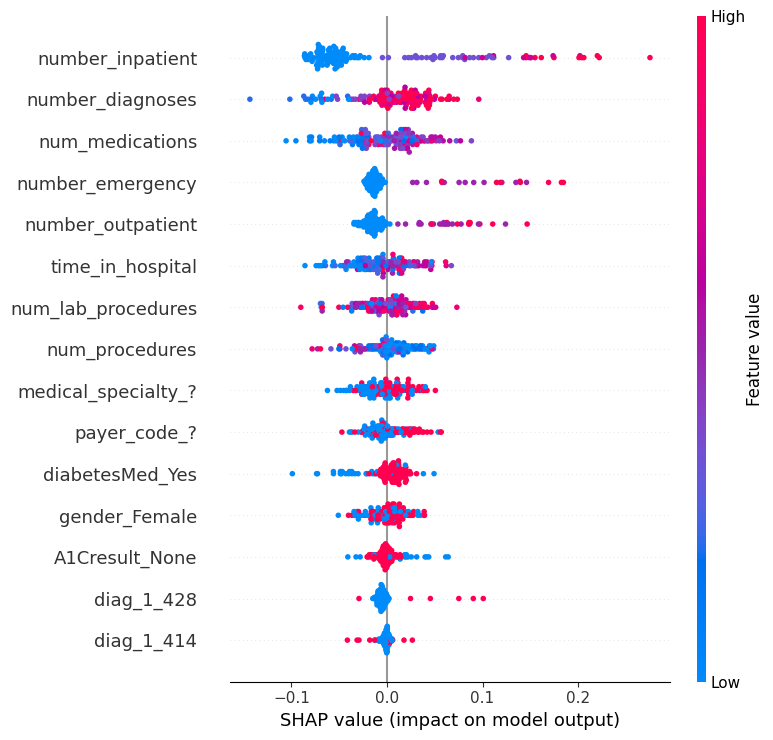

In [43]:
data = pd.read_csv('hospital-readmissions.csv')
y = data.readmitted
base_features = ['number_inpatient', 'num_medications', 'number_diagnoses', 'num_lab_procedures', 
                 'num_procedures', 'time_in_hospital', 'number_outpatient', 'number_emergency', 
                 'gender_Female', 'payer_code_?', 'medical_specialty_?', 'diag_1_428', 'diag_1_414', 
                 'diabetesMed_Yes', 'A1Cresult_None']

X = data[base_features].astype(float)
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
# For speed, we will calculate shap values on smaller subset of the validation data
small_val_X = val_X.iloc[:150]
my_model = RandomForestClassifier(n_estimators=30, random_state=1).fit(train_X, train_y)
import numpy as np
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(small_val_X)
print(type(shap_values))         # liste ou array ?
print(np.shape(shap_values))     # quelles dimensions ?
print(small_val_X.shape)
print(np.shape(shap_values[:, :, 1]))
shap.summary_plot(shap_values[:, :, 1], small_val_X)

## Question 1

Which of the following features has a bigger range of effects on predictions (i.e. larger difference between most positive and most negative effect)
- `diag_1_428` or
- `payer_code_?`

*/// set following variable to 'diag_1_428' or 'payer_code_?'
feature_with_bigger_range_of_effects = 'diag_1_428'

## Question 2

Do you believe the range of effects sizes (distance between smallest effect and largest effect) is a good indication of which feature will have a higher permutation importance? Why or why not?  

If the **range of effect sizes** measures something different from **permutation importance**: which is a better answer for the question "Which of these two features does the model say is more important for us to understand when discussing readmission risks in the population?"

**Solution**: No. The width of the effects range is not a reasonable approximation to permutation importance. For that matter, the width of the range doesn't map well to any intuitive sense of "importance" because it can be determined by just a few outliers. However if all dots on the graph are widely spread from each other, that is a reasonable indication that permutation importance is high. Because the range of effects is so sensitive to outliers, permutation importance is a better measure of what's generally important to the model.

## Question 3

Both `diag_1_428` and `payer_code_?` are binary variables, taking values of 0 or 1.

From the graph, which do you think would typically have a bigger impact on predicted readmission risk:
- Changing `diag_1_428` from 0 to 1
- Changing `payer_code_?` from 0 to 1

**Solution**: While most SHAP values of diag_1_428 are small, the few pink dots (high values of the variable, corresponding to people with that diagnosis) have large SHAP values. In other words, the pink dots for this variable are far from 0, and making someone have the higher (pink) value would increase their readmission risk significantly. In real-world terms, this diagnosis is rare, but poses a larger risk for people who have it. In contrast, payer_code_? has many values of both blue and pink, and both have SHAP values that differ meaningfully from 0. But changing payer_code_? from 0 (blue) to 1 (pink) is likely to have a smaller impact than changing diag_1_428.

## Question 4

Some features (like `number_inpatient`) have reasonably clear separation between the blue and pink dots. Other variables like `num_lab_procedures` have blue and pink dots jumbled together, even though the SHAP values (or impacts on prediction) aren't all 0.

What do you think you learn from the fact that `num_lab_procedures` has blue and pink dots jumbled together?

**Solution**: The jumbling suggests that sometimes increasing that feature leads to higher predictions, and other times it leads to a lower prediction. Said another way, both high and low values of the feature can have both positive and negative effects on the prediction. The most likely explanation for this "jumbling" of effects is that the variable (in this case num_lab_procedures) has an interaction effect with other variables. For example, there may be some diagnoses for which it is good to have many lab procedures, and other diagnoses where suggests increased risk. We don't yet know what other feature is interacting with num_lab_procedures though we could investigate that with SHAP contribution dependence plots.



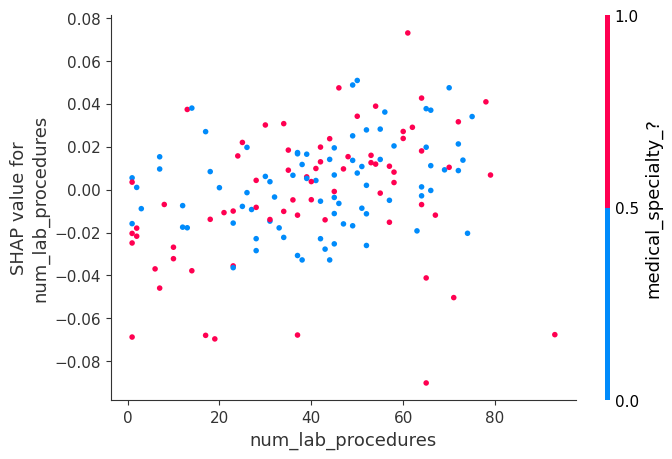

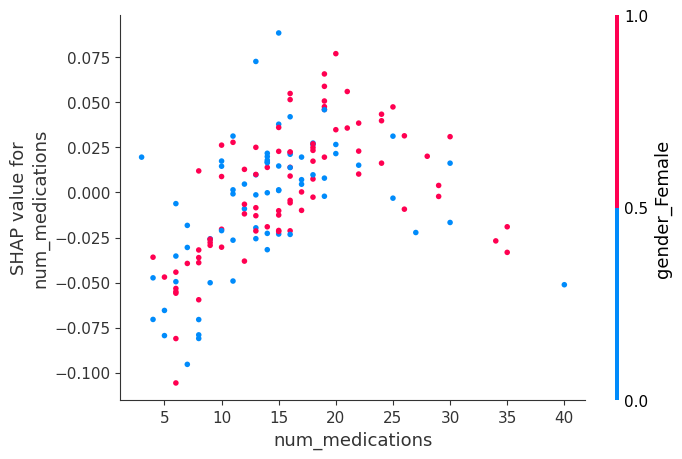

In [44]:
shap.dependence_plot('num_lab_procedures', shap_values[:, :, 1], small_val_X)
shap.dependence_plot('num_medications', shap_values[:, :, 1], small_val_X)

Loosely speaking, num_lab_procedures looks like a cloud with little disernible pattern. It does not slope steeply up nor down at any point. It's hard to say we've learned much from that plot. At the same time, the values are not all very close to 0. So the model seems to think this is a relevant feature. One potential next step would be to explore more by coloring it with different other features to search for an interaction.

On the other hand, num_medications clearly slopes up until a value of about 20, and then it turns back down. Without more medical background, this seems a surprising phenomenon... You could do some exploration to see whether these patients have unusual values for other features too. But a good next step would be to discuss this phenomenon with domain experts (in this case, the doctors).

## Congratulations

That's it!  Machine learning models should not feel like black boxes any more, because we have the tools to inspect them and understand what they learn about the world. 

This is an excellent skill for debugging models, building trust, and learning insights to make better decisions. These techniques have revolutionized how I do data science, and I hope they do the same for you.